In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from helper_methods import *
from custom_models.cnn import CNN
import seaborn as sns
import matplotlib.pyplot as plt
from custom_models.methods import fit, evaluate_network


In [10]:
# set seaborn style
sns.set_theme(context='notebook', style='whitegrid', palette='bright', color_codes=True, rc=None)

In [11]:
(
    train_loader,
    train_loader_at_eval,
    test_loader,
    validation_loader,
    n_channels,
    n_classes,
    task,
    pil_dataset,
) = get_data_loaders()

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz


In [12]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(f"Device: {device}")

Device: cuda


In [13]:
# first sample
sample = next(iter(train_loader))

print(f"Sample Shape: {sample[0].shape}")

# No of Neurons in Input Layer
# Output is flattened before feeding to MLP
input_size = n_channels * sample[0].shape[2] * sample[0].shape[3]

# No of Neurons in Hidden Layers
# hidden_sizes = [256, 128]

# No of Neurons in Output Layer
num_classes = n_classes

Sample Shape: torch.Size([128, 3, 28, 28])


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)


Epoch [1/25], Training Loss: 1.1402085304260254, Validation Loss: 1.0291633754968643
Epoch [2/25], Training Loss: 0.9884164463390004, Validation Loss: 0.9503723531961441
Epoch [3/25], Training Loss: 0.9206800005652688, Validation Loss: 0.8776671290397644
Epoch [4/25], Training Loss: 0.8777344757860357, Validation Loss: 0.8475904613733292
Epoch [5/25], Training Loss: 0.8418714165687561, Validation Loss: 0.8450265377759933
Epoch [6/25], Training Loss: 0.8202799601988359, Validation Loss: 0.7787215560674667
Epoch [7/25], Training Loss: 0.7738307877020403, Validation Loss: 0.755057081580162
Epoch [8/25], Training Loss: 0.7362126447937706, Validation Loss: 0.7448531538248062
Epoch [9/25], Training Loss: 0.7251576781272888, Validation Loss: 0.7237708270549774
Epoch [10/25], Training Loss: 0.7283043037761342, Validation Loss: 0.7024520039558411
Epoch [11/25], Training Loss: 0.71868238882585, Validation Loss: 0.7364226579666138
Epoch [12/25], Training Loss: 0.6868467092514038, Validation Loss:

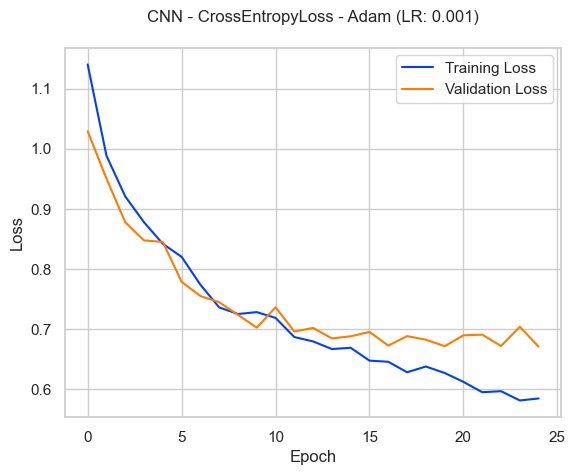

In [14]:
N_EPOCHS = 25
LR = 0.001

cnn = CNN(input_channels=n_channels, num_classes=num_classes)

print(cnn)

# Loss Function
# this criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
# It expects the target to be class indices (not one-hot encoded)
criterion = nn.CrossEntropyLoss()

# criterion = nn.MultiMarginLoss()

# Optimizer
optimizer = optim.Adam(cnn.parameters(), lr=LR)

cnn_loss_values, cnn = fit(
    training_data=train_loader,
    validation_data=validation_loader,
    nn=cnn,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    to_device=True,
    flatten_input=False,
)

model_title = f"CNN - {criterion.__class__.__name__} - {optimizer.__class__.__name__} (LR: {LR})\n"

plot_losses(cnn_loss_values, model_title)

In [15]:
# Evaluate the model

# On Training Data
evals_training = evaluate_network(
    nn=cnn,
    test_data=train_loader_at_eval,
    to_device=True,
    flatten_input=False,
)

# On Test Data
evals_test = evaluate_network(
    nn=cnn,
    test_data=test_loader,
    to_device=True,
    flatten_input=False,
)

training_cm = evals_training.pop("cm")
test_cm = evals_test.pop("cm")


Eval on Training Data:

acc: 0.7916369344940773
f1_global: 0.7916369344940773
f1_unweighted: 0.5492324696224228
f1_weighted: 0.7713003063511076



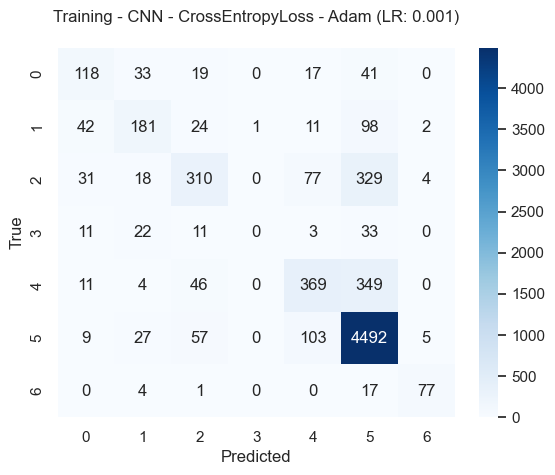

Eval on Test Data: 

acc: 0.7451371571072319
f1_global: 0.7451371571072319
f1_unweighted: 0.473898120642776
f1_weighted: 0.7236400870723212



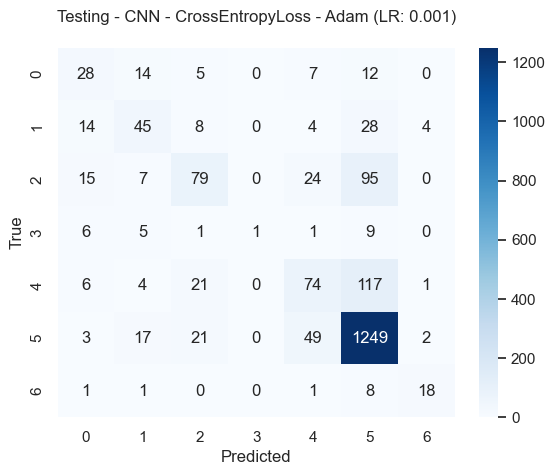

In [16]:
print(f"Eval on Training Data:\n")
print_eval(evals_training)

plot_7_class_confusion_matrix(
    training_cm,
    "Training - " + model_title,
)

print(f"Eval on Test Data: \n")
print_eval(evals_test)

plot_7_class_confusion_matrix(
    test_cm,
    "Testing - " + model_title,
)